# DEMO: Predicting day-ahead energy consumption

In [9]:
from datetime import datetime as dt, timedelta
import pandas as pd
import numpy as np
import loadForecast as lf
import mpld3
mpld3.enable_notebook()
%matplotlib inline

In [11]:
f = 'data/NCENT.csv'
df = pd.read_csv(f)
all_X = lf.makeUsefulDf(df).to_numpy()
all_y = df['load'].to_numpy()
# convert boolean features into float32 variables
all_X = np.asarray(all_X).astype(np.float32)
#print(all_X.shape, all_y.shape)
#print(all_X, all_y)
predictions, accuracy = lf.neural_net_predictions(all_X, all_y)

2022-02-07 17:20:05.373508: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-07 17:20:05.375832: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-07 17:20:11.728212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 17:23:04.166202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 17:23:04.647953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Percent accuracy (MAPE). Train: 95.52443887087581.  Test: 95.36193821021037


<AxesSubplot:title={'center':'NCENT Texas 2018: prediction v. actual load'}>

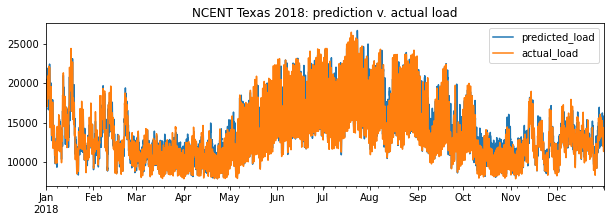

In [12]:
print('Percent accuracy (MAPE). Train: {}.  Test: {}'.format(100-accuracy['train'], 100-accuracy['test']))

df_r = pd.DataFrame()
df_r['predicted_load'] = predictions
df_r['actual_load'] = [float(f) for f in all_y[-8760:]]
df_r.index = [dt(2018, 1, 1, 0) + timedelta(hours=1)*i for i in range(8760)]
df_r.plot(figsize=(10, 3), title="NCENT Texas 2018: prediction v. actual load")